## Introduction

A lot is going on in this post, but our ultimate goal is to conduct a robustness study.

From the [previous post](https://cgcooke.github.io/Blog/bayesian/pymc3/finance/monte%20carlo%20simulation/afterpay/2020/08/22/Afterpay-Customer-Defaults-Part-2.html), I looked at how to model customer late payment rates from a single distribution. Now I want to turn things up a notch and model it using a range of distributions from two different families. 

To achieve this, we need to:

1. Compute distributions of late fees rapidly.
2. Compute the average late fee under a wide range of assumptions.
3. Find the distribution of how frequent late payments are.

:::{.callout-important}

Obviously, I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.

:::

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy.stats as st

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

## Improving performance

### Direct Model

As part of our simulation, we need to know the distribution of late fees for any given probability of late payment.

We can directly model this in PyMC3, using the Binomial distribution to model the number of times someone makes a late payment. While this model directly models what happens in reality, it takes 3 seconds to generate 100,000 samples.

In [2]:
def create_late_fee_distribution(late_payment_probability, num_samples=100_000):
    with pm.Model() as fee_model:
        number_of_delays_of_less_than_1_week = 1 + pm.Binomial('number_of_delays_of_less_than_1_week', n=3, p=late_payment_probability)
        number_of_delays_of_more_than_1_week = pm.Binomial('number_of_delays_of_more_than_1_week', n=number_of_delays_of_less_than_1_week, p=late_payment_probability)
        total_fees = pm.Deterministic('total_fees',10 * number_of_delays_of_less_than_1_week + 7 * number_of_delays_of_more_than_1_week)

        samples = pm.sample_prior_predictive(samples = num_samples, random_seed=0)
    return(samples)

Now let's visualise the distribution we would see if a customer has a 50% chance of defaulting on any given payment.

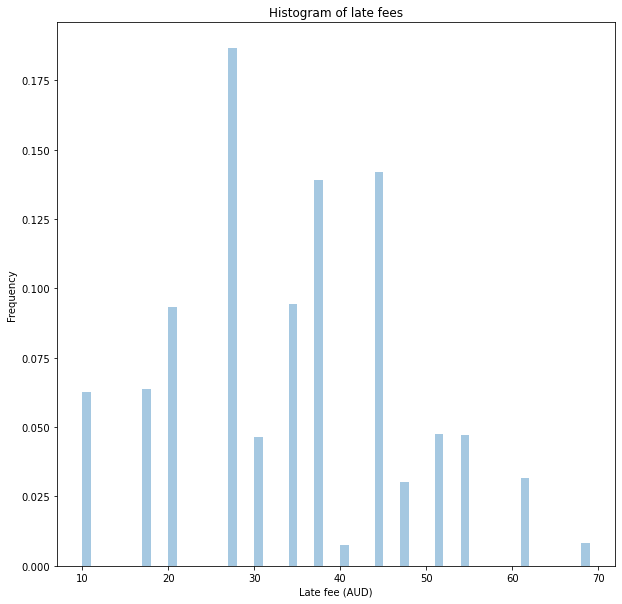

In [3]:
samples = create_late_fee_distribution(late_payment_probability = 0.5)

sns.distplot(samples["total_fees"],kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.title('Histogram of late fees')
plt.ylabel('Frequency')
plt.xlabel('Late fee (AUD)')
plt.show()

### Categorical Model

One solution to enable us to sample faster is to capture the output from the direct model, which precisely models the underlying process, and to create a surrogate model. This model uses a categorical distribution to generate samples with the same distribution efficiently.

We can generate 100,000 samples in only 60ms, a 50 fold speedup using this surrogate model.

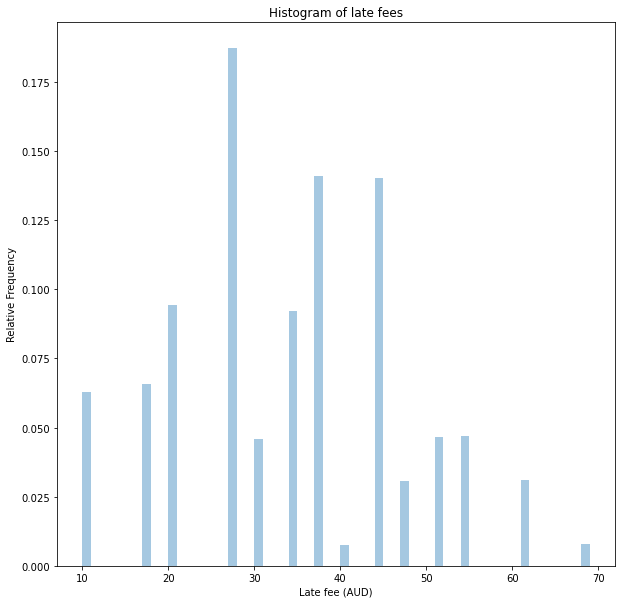

In [4]:
def create_late_fee_surrogate_distribution(late_fee_samples):
    unique, counts = np.unique(late_fee_samples, return_counts=True) 
    
    categorical_map = {}
    for i in range(len(unique)):
        categorical_map[i] = unique[i]
    
    with pm.Model() as categorical_fee_model:
        late_fee_distribution_categorical = pm.Categorical('late_fee_distribution_categorical',counts)
    
    return(categorical_fee_model, categorical_map)

def generate_samples(categorical_fee_model, categorical_map):
    with categorical_fee_model:
        samples = pm.sample_prior_predictive(samples=100_000)

    late_fee_samples = np.zeros_like(samples["late_fee_distribution_categorical"])

    for i in range(len(categorical_map.keys())):
        late_fee_samples[samples["late_fee_distribution_categorical"] == i] = categorical_map[i]

    return(late_fee_samples)

categorical_fee_model, categorical_map = create_late_fee_surrogate_distribution(samples["total_fees"])

late_fee_samples = generate_samples(categorical_fee_model, categorical_map)

plt.title('Histogram of late fees')
plt.ylabel('Relative Frequency')
plt.xlabel('Late fee (AUD)')
sns.distplot(late_fee_samples,kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.show()

## Grid Evaluation

We can now find the average late fee under a range of different combinations of late payment probability and average transaction size.

First off, let's create a dictionary of categorical models, so we can quickly draw new samples.

In [5]:
fee_models = {}
for late_payment_probability_percent in range(0, 101,5):
    samples = create_late_fee_distribution(late_payment_probability = late_payment_probability_percent/100.0) 
    fee_models[late_payment_probability_percent] = create_late_fee_surrogate_distribution(samples["total_fees"])

Now it's time to generate the grid.

In [6]:
def perform_parametric_study(transaction_value_sampling_function):
    grid = np.zeros((21,20))
    for average_transaction_value_aud in range(50,250,10):

        transaction_value_samples = transaction_value_sampling_function(average_transaction_value_aud)
        for late_payment_probability_percent in range(0, 101,5):
            categorical_fee_model, categorical_map = fee_models[late_payment_probability_percent]

            #Draw a distribution of late fees
            late_fee_samples = generate_samples(categorical_fee_model,categorical_map)

            #Limit the late fees to be at at most 25% of the transaction value
            late_fees = np.minimum(late_fee_samples, 0.25*transaction_value_samples)
            #And at least $10 AUD
            late_fees = np.maximum(late_fees,10)

            mean_late_fee = np.mean(late_fees)

            grid[int(late_payment_probability_percent/5), int((average_transaction_value_aud-50)/10)] = mean_late_fee
            
    return(grid)

In [7]:
def visualise_grid(grid,title):
    x_axis_labels = range(50,250,10) 
    y_axis_labels = range(0, 101,5)

    sns.heatmap(grid,xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar_kws={'label': 'Average late fee (AUD)'},annot=True)
    plt.xlabel('Average Transaction Value (AUD)')
    plt.ylabel('Probability of late payment on any transaction (%)')
    plt.title(title)
    plt.show()

## Distributions

One of the big unknowns is the distribution of the transactions where there are late payments. 
To provide some robustness in our modelling, I'm using two different families of distributions. 

1. The Exponential distribution
2. The Half Normal distribution

For each family of distributions, I will generate distributions with means in the range of 50-250 AUD. 

This, in turn, will help provide a level of conservatism and robustness to our modelling.

### Exponential distribution

In [ ]:
x = np.linspace(0, 1500,1500)
for average_transaction_value_aud in range(50,250,10):
    pdf = st.expon.pdf(x, scale = average_transaction_value_aud )
    plt.plot(x, pdf,color='k',alpha=0.5)
plt.xlabel('Transaction Value (AUD')
plt.ylabel('Relative Frequency')
plt.show()

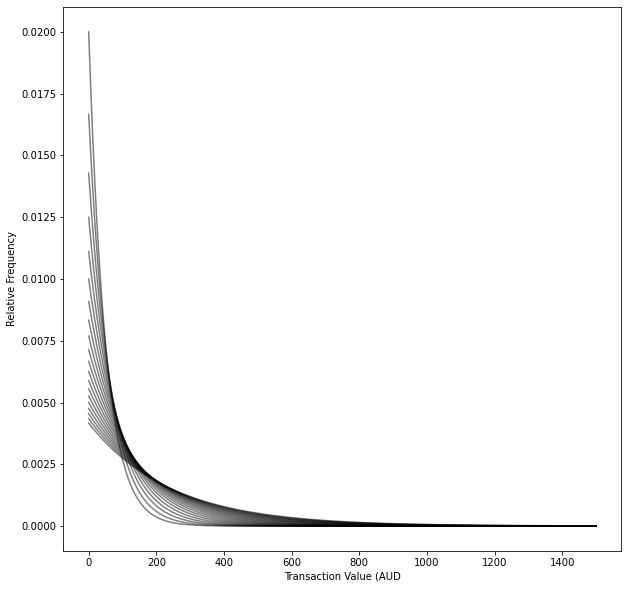

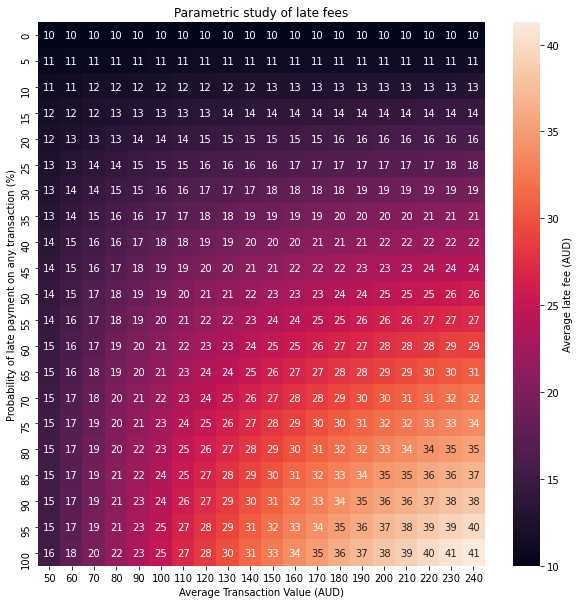

In [9]:
def create_exponential_transaction_value_samples(average_transaction_value_aud):
    with pm.Model() as transaction_value_model:
        transaction_value_aud = pm.Bound(pm.Exponential, upper=1_500.0)('transaction_value_aud', lam = 1/average_transaction_value_aud)
        transaction_value_samples = pm.sample_prior_predictive(samples=100_000)
        transaction_value_samples = transaction_value_samples['transaction_value_aud']
    return(transaction_value_samples)    

exponential_grid = perform_parametric_study(create_exponential_transaction_value_samples)
visualise_grid(exponential_grid,'Parametric study of late fees')

### Half Normal Distribution

In [ ]:
x = np.linspace(0, 1500,1500)
for average_transaction_value_aud in range(50,250,10):
    sigma = average_transaction_value_aud * np.sqrt(np.pi) /  np.sqrt(2)  
    pdf = st.halfnorm.pdf(x, scale=sigma)
    plt.plot(x, pdf,color='k',alpha=0.5)
plt.xlabel('Transaction Value (AUD')
plt.ylabel('Relative Frequency')
plt.show()

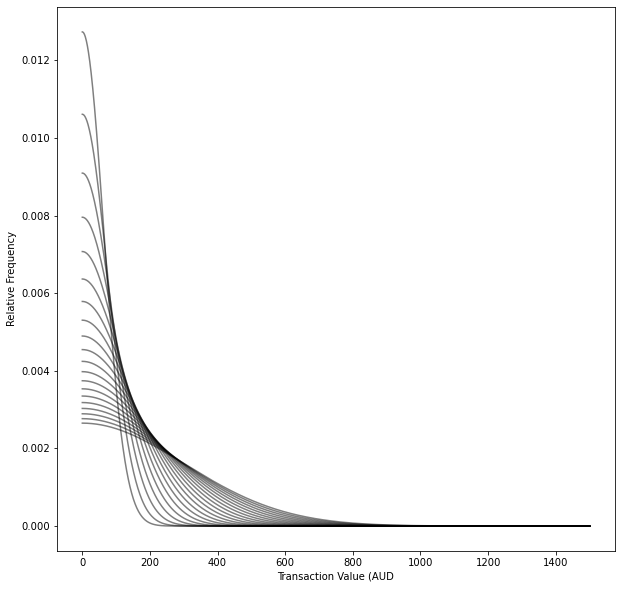

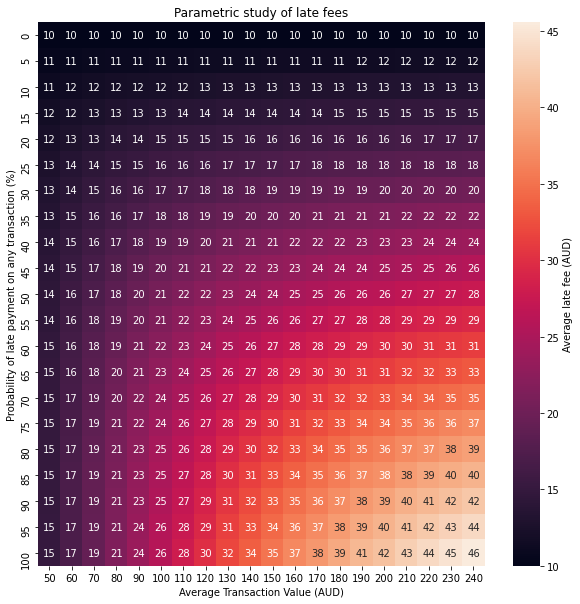

In [10]:
def create_halfnormal_transaction_value_samples(average_transaction_value_aud):
    sigma = average_transaction_value_aud * np.sqrt(np.pi) /  np.sqrt(2)     
    with pm.Model() as transaction_value_model:
        transaction_value_aud = pm.Bound(pm.HalfNormal,lower=0, upper=1_500.0)('transaction_value_aud', sigma = sigma)
        transaction_value_samples = pm.sample_prior_predictive(samples = 100_000)
        transaction_value_samples = transaction_value_samples['transaction_value_aud']
    return(transaction_value_samples)    


halfnormal_grid = perform_parametric_study(create_halfnormal_transaction_value_samples)
visualise_grid(halfnormal_grid,'Parametric study of late fees')

## Updating our Priors

In a [previous](https://cgcooke.github.io/Blog/bayesian/pymc3/finance/monte%20carlo%20simulation/afterpay/2020/08/21/Afterpay-Customer-Defaults-Part-1.html) post, we developed a model for calculating the distribution of transactions attracting late fees. One of the assumptions that we used was that the average late fee was uniformly distributed between 10 AUD and 68 AUD. 

Given what we now know, we can find a more realistic distribution. I've chosen to go with a Half Normal, which fits quite well.

Offset: 10.00, Standard Deviation: 14.30


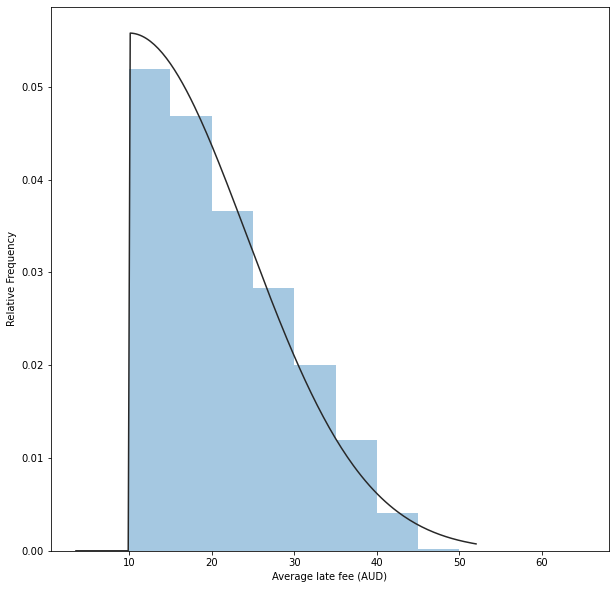

In [32]:
late_fees_aggregated = np.stack([halfnormal_grid, exponential_grid]).ravel()

offset, std = st.halfnorm.fit(late_fees_aggregated)

print('Offset: {:0.2f}, Standard Deviation: {:0.2f}'.format(offset,std))

sns.distplot(late_fees_aggregated,fit=st.halfnorm,  kde=False, bins = np.arange(10,68,5))
plt.ylabel('Relative Frequency')
plt.xlabel('Average late fee (AUD)')
plt.show()

We can also find the average late fee (21.7 AUD).

In [16]:
pm.summary(late_fees_aggregated)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 840), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,21.673,8.264,10.0,36.41,2.541,1.849,11.0,11.0,10.0,40.0,NaN


Now let's re-do the model from [this](https://cgcooke.github.io/Blog/bayesian/pymc3/finance/monte%20carlo%20simulation/afterpay/2020/08/21/Afterpay-Customer-Defaults-Part-1.html) post, except now using an updated distribution for the late fee:    

In [20]:
with pm.Model() as model:
    underlying_sales_aud = pm.Uniform('underlying_sales_aud', lower=5.24715*10**9, upper=5.247249*10**9)
    
    late_fees_rev_aud = pm.Uniform('late_fees_rev', lower=46.05 * 10**6, upper=46.149 * 10**6)
    
    average_transaction_value_aud = pm.Uniform('average_transaction_value', lower=144.50, upper=154.49)
    
    #The updated distribution
    average_late_fee_aud = 10 + pm.HalfNormal('average_late_fee',sigma = 14.298)
    
    number_of_transactions = pm.Deterministic('number_of_transactions', underlying_sales_aud / average_transaction_value_aud)
    
    late_payment_rate = pm.Deterministic('late_payment_rate',late_fees_rev_aud / (number_of_transactions * average_late_fee_aud))
    

We can now sample this distribution and find an updated distribution.

In [21]:
with model:
    samples = pm.sample_prior_predictive(samples=50_000, random_seed=0)

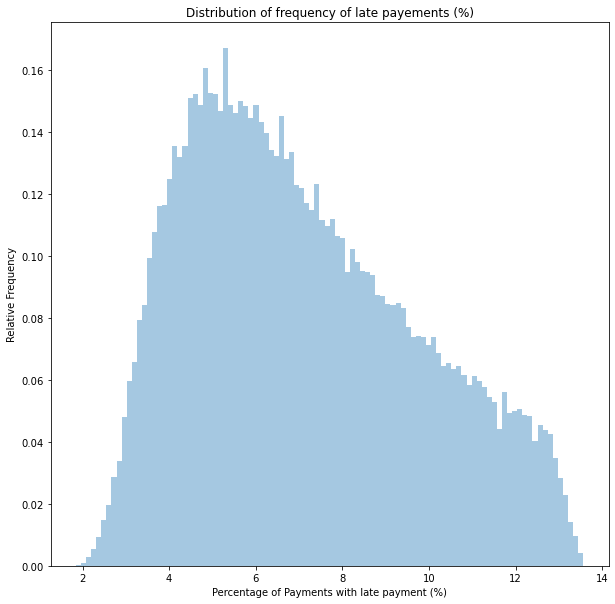

In [23]:
sns.distplot(100*samples["late_payment_rate"], kde=False, norm_hist=True, bins=100)
plt.title('Distribution of frequency of late payements (%)')
plt.xlabel('Percentage of transactions with late payment (%)')
plt.ylabel('Relative Frequency')
plt.show()

In [25]:
pm.summary(100*samples["late_payment_rate"])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,7.11,2.644,3.011,12.23,0.012,0.008,50870.0,50799.0,50628.0,49878.0,NaN


## Conclusion

Based on our analysis and making some conservative assumptions, we can see that the average late fee is likely to be in the range of 10 to 36 AUD.

If we use the distribution of late fees as an updated input to the model we developed in [this](https://cgcooke.github.io/Blog/bayesian/pymc3/finance/monte%20carlo%20simulation/afterpay/2020/08/21/Afterpay-Customer-Defaults-Part-1.html) post, we find that between 3 and 12% of transactions are attracting late fees.  Overall, our best estimate is 7%.